<a href="https://colab.research.google.com/github/Svetorus/Data-Science/blob/main/DZ_log_regression_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Классификация. Логистическая регрессия и SVM

In [ ]:
import pandas as pd # Для работы с данными
import numpy as np
import itertools
import random
from google.colab import files # Библиотека для загрузки файлов

import scipy.stats # При работе со статистикой
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.svm import SVC
 
import seaborn as sns # Библиотека для визуализации результатов
from matplotlib import pyplot as plt # Библиотека для визуализации результатов
%matplotlib inline

In [ ]:
# !pip install catboost

In [ ]:
# загрузка из компа в google colab
uploaded = files.upload()

Saving adult.csv to adult (3).csv


In [ ]:
data = pd.read_csv('adult.csv')

In [ ]:
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


Обзор данных

In [ ]:
data.iloc[0]

age                               25
workclass                    Private
fnlwgt                        226802
education                       11th
educational-num                    7
marital-status         Never-married
occupation         Machine-op-inspct
relationship               Own-child
race                           Black
gender                          Male
capital-gain                       0
capital-loss                       0
hours-per-week                    40
native-country         United-States
income                         <=50K
Name: 0, dtype: object

Смотрим данные по файлу

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


Количество пропущенных значений (в процентах)

In [ ]:
round((len(data) - data.count()) / len(data) * 100, 2).sort_values(ascending=False).head()

age                0.0
workclass          0.0
fnlwgt             0.0
education          0.0
educational-num    0.0
dtype: float64

Количество уникальных значений по каждому из признаков

In [ ]:
data.nunique().sort_values()

gender                 2
income                 2
race                   5
relationship           6
marital-status         7
workclass              9
occupation            15
education             16
educational-num       16
native-country        42
age                   74
hours-per-week        96
capital-loss          99
capital-gain         123
fnlwgt             28523
dtype: int64

Приведение типов

In [ ]:
data.dtypes

age                 int64
workclass          object
fnlwgt              int64
education          object
educational-num     int64
marital-status     object
occupation         object
relationship       object
race               object
gender             object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
income             object
dtype: object

## Формирование списков признаков

In [ ]:
TARGET_NAME = 'income'
NUM_FEATURE_NAMES = data.select_dtypes(include='int64').columns.tolist()
CAT_FEATURE_NAMES = data.select_dtypes(include='object').columns.tolist()

Анализ целевой переменной

In [ ]:
data[TARGET_NAME].value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

## Количественные признаки в разрезе целевой переменной

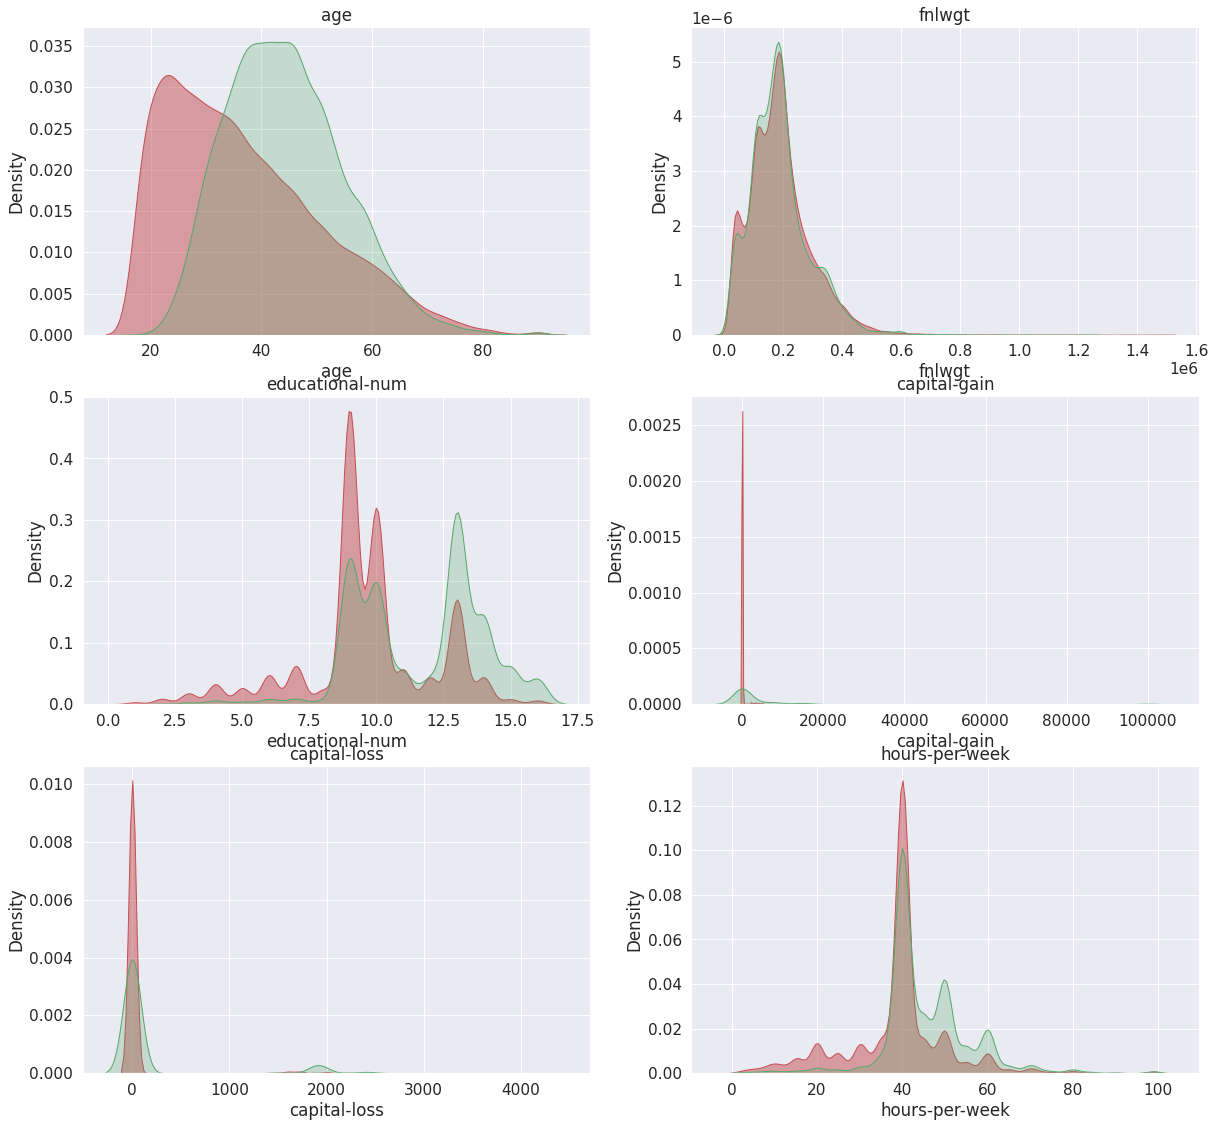

In [ ]:
sns.set(font_scale=1.4)
plt.figure(figsize=(20,60))

for i, colname in enumerate(NUM_FEATURE_NAMES):
    plt.subplot(9,2,i+1)
    plt.title(colname)
    sns.kdeplot(data.loc[data[TARGET_NAME] == '<=50K', colname], shade=True, alpha=0.5, legend=False, color='r')
    sns.kdeplot(data.loc[data[TARGET_NAME] == '>50K', colname], shade=True, legend=False, color='g')
    
plt.show()

## Категориальные признаки в разрезе целевой переменной

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
data

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


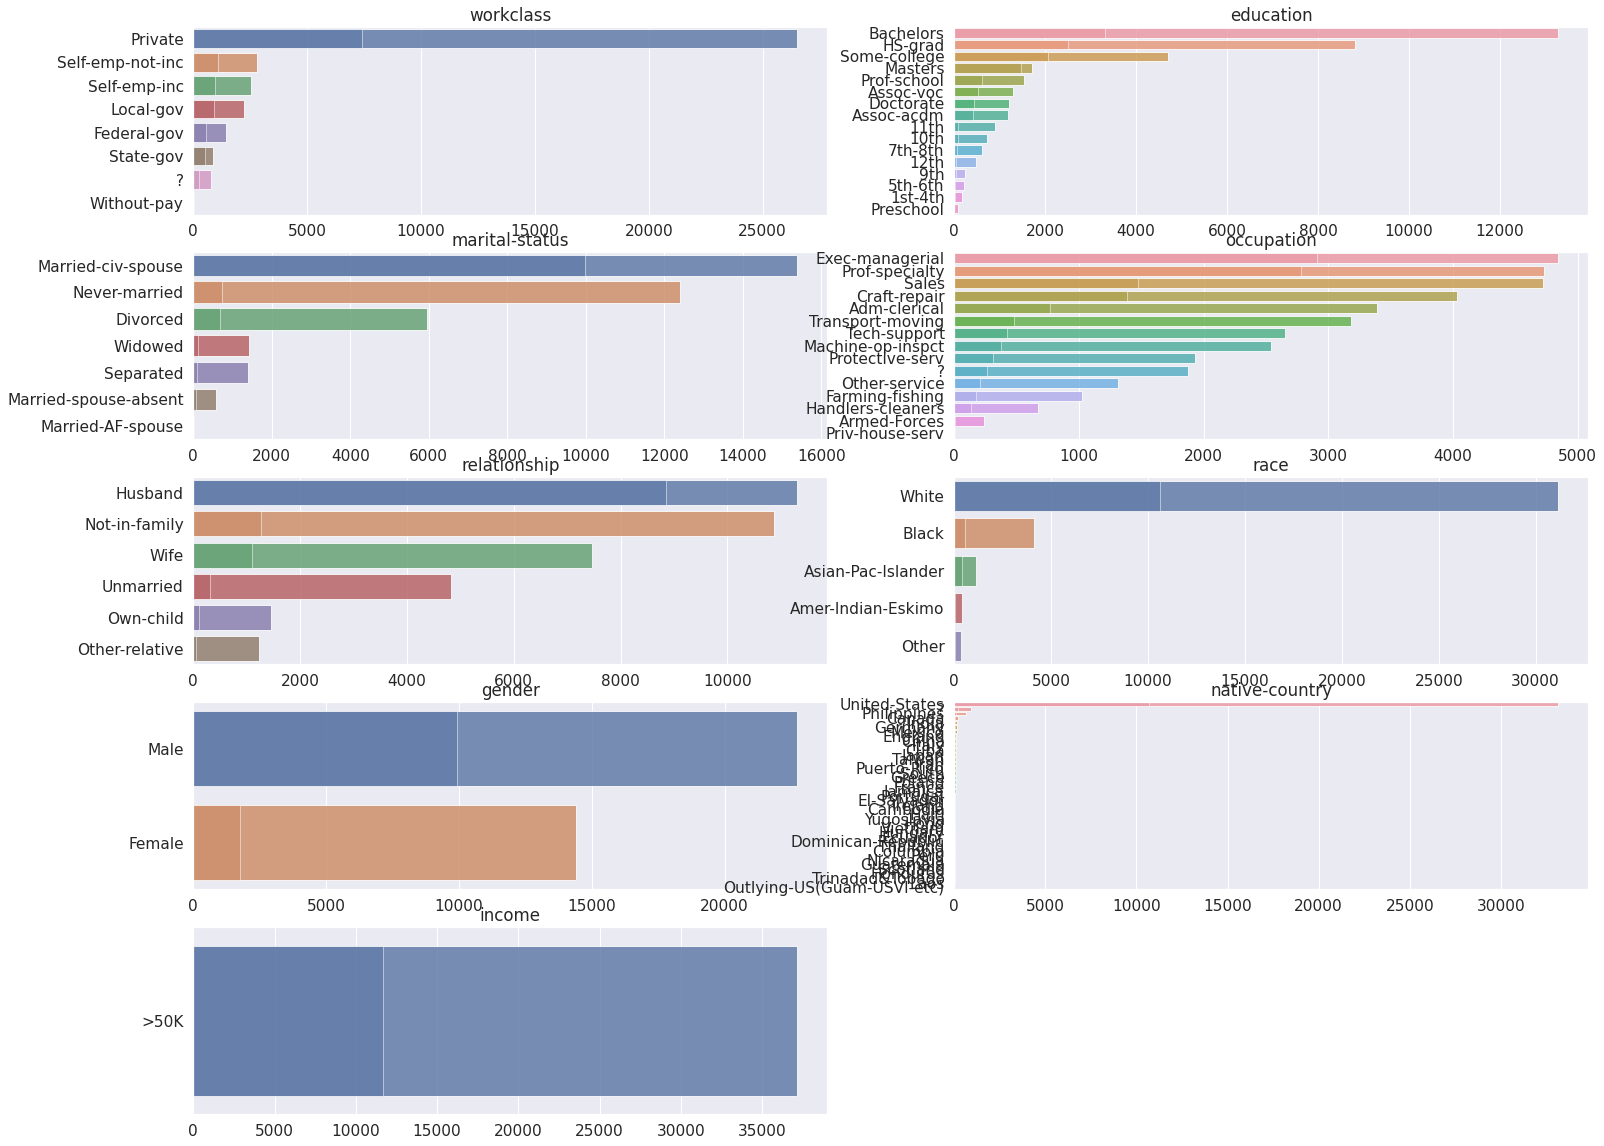

In [ ]:
sns.set(font_scale=1.4)
plt.figure(figsize=(25,20))

for i, colname in enumerate(CAT_FEATURE_NAMES):
    plt.subplot(5,2,i+1)
    plt.title(colname)
    
    val_counts_t1 = data.loc[data[TARGET_NAME] == '<=50K', colname].value_counts()
    val_counts_t0 = data.loc[data[TARGET_NAME] == '>50K', colname].value_counts()
    
    sns.barplot(val_counts_t1.values, val_counts_t1.index, alpha=0.8)
    sns.barplot(val_counts_t0.values, val_counts_t0.index, alpha=0.5)
    
plt.show()

Оценка корреляций с целевой переменной

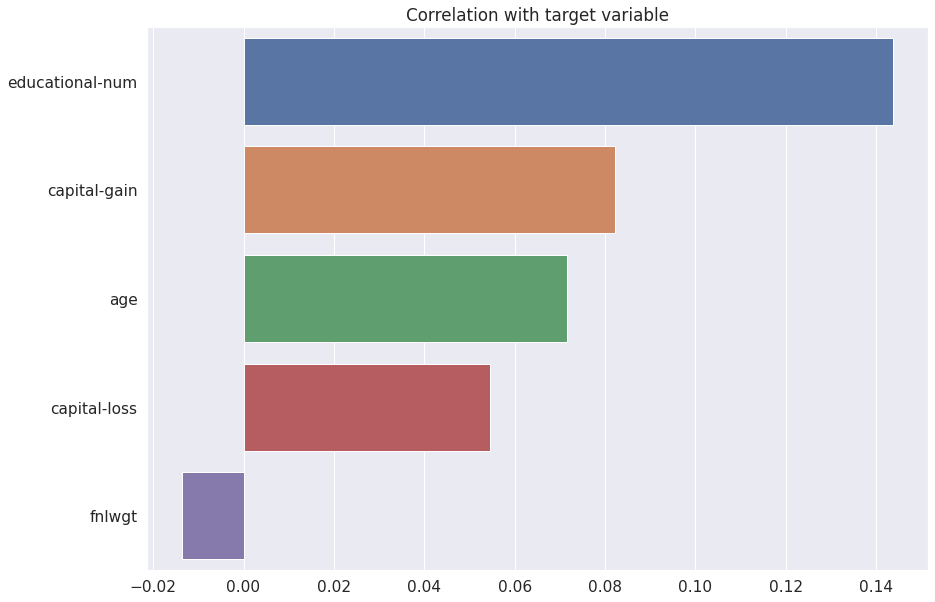

In [ ]:
corr_with_target = data.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(14, 10))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

## Анализ линейных зависимостей в признаковом пространстве

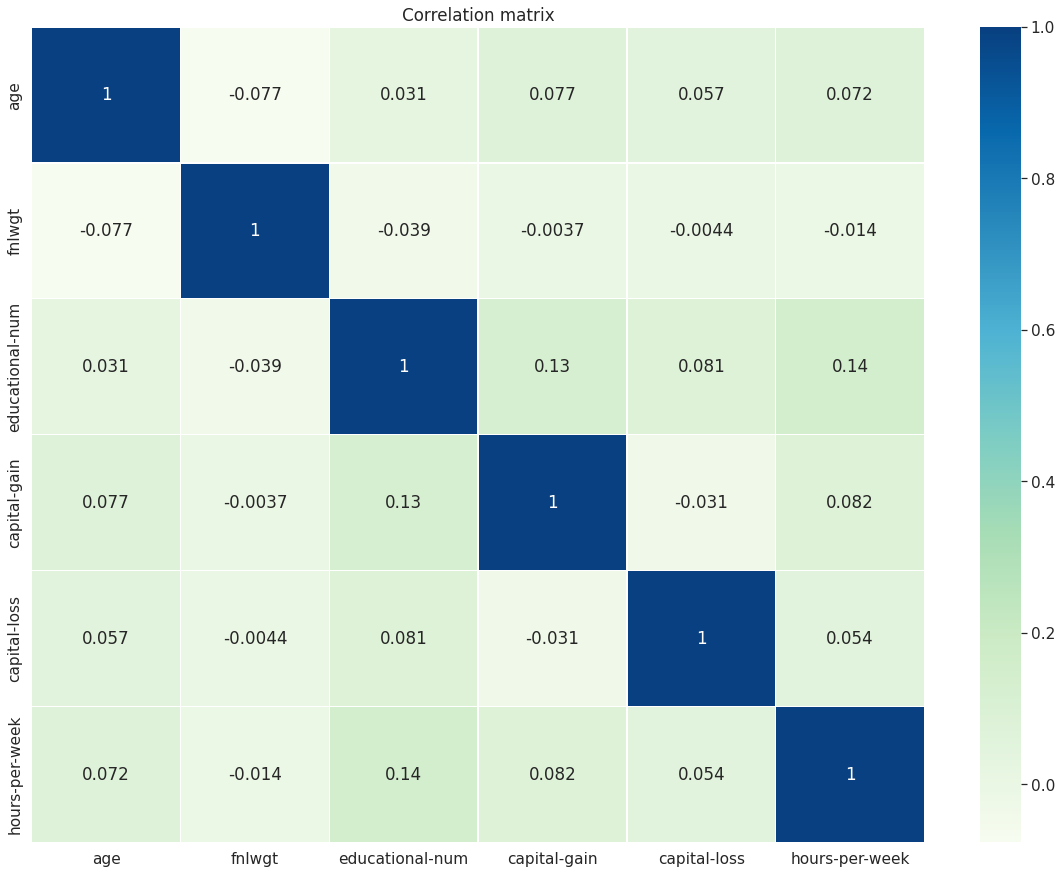

In [ ]:
plt.figure(figsize=(20,15))

sns.set(font_scale=1.4)
sns.heatmap(data.drop(columns=TARGET_NAME).corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [ ]:
data.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [ ]:
data = data.rename(index=str, columns={"educational-num": "educational_num","marital-status": "marital_status","capital-gain": "capital_gain","capital-loss": "capital_loss","hours-per-week": "hours_per_week","native-country": "native_country"})

In [ ]:
# data['capital_gain'].nlargest()

In [ ]:
# data.query("capital_gain == 99999").count()

In [ ]:
# data['capital-gain'].unique()

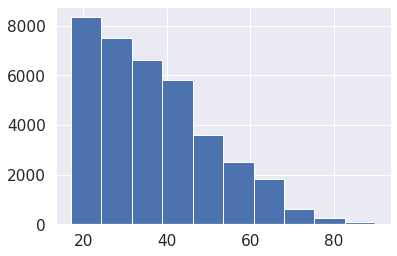

In [ ]:
data.loc[data[TARGET_NAME] == '<=50K', 'age'].hist();

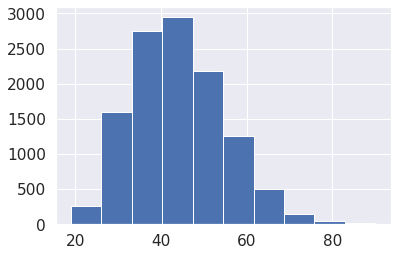

In [ ]:
data.loc[data[TARGET_NAME] == '>50K', 'age'].hist();

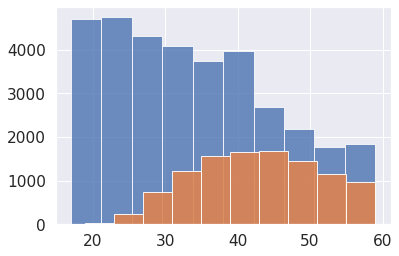

In [ ]:
data.loc[(data['age'] < 60) & (data[TARGET_NAME] == '<=50K'), 'age'].hist(alpha=0.8);
data.loc[(data['age'] < 60) & (data[TARGET_NAME] == '>50K'), 'age'].hist(alpha=0.9);

In [ ]:
data.tail()

,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
48841,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [ ]:
# сохраняеи данные до кодинга
df = data

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
# data.select_dtypes(include='object')

In [ ]:
data[['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'native_country', 'income']].head(5)

,workclass,education,marital_status,occupation,relationship,race,gender,native_country,income
0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,United-States,<=50K
1,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States,<=50K
2,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States,>50K
3,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,United-States,>50K
4,?,Some-college,Never-married,?,Own-child,White,Female,United-States,<=50K


## переводим категориальные в количественные 

In [ ]:
data[['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'native_country', 'income']] = data.select_dtypes(include='object').apply(le.fit_transform)

In [ ]:
data[['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'native_country', 'income']].head(5)

,workclass,education,marital_status,occupation,relationship,race,gender,native_country,income
0,4,1,4,7,3,2,1,39,0
1,4,11,2,5,0,4,1,39,0
2,2,7,2,11,0,4,1,39,1
3,4,15,2,7,0,2,1,39,1
4,0,15,4,0,3,4,0,39,0


In [ ]:
# data.head()

In [ ]:
# сохраняеи данные до нормализации
df_1 = data

## Нормализация данных

In [ ]:
scaler = StandardScaler()

data.iloc[:, :-1] = scaler.fit_transform(data.iloc[:, :-1])

## Разбиение на train и test

In [ ]:
X = data.drop(columns=TARGET_NAME)
y = data[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42)

## Балансировка целевой переменной  
Расчет весов для классов

In [ ]:
# compute_class_weight('balanced', np.array([0, 1]), data[TARGET_NAME])

## Базовая модель

In [ ]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

## CatBoostClassifier

In [ ]:
model_catb = catb.CatBoostClassifier(class_weights=[0.7, 1.8], silent=True, random_state=42)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.87      0.91     29676
           1       0.68      0.88      0.77      9397

    accuracy                           0.87     39073
   macro avg       0.82      0.88      0.84     39073
weighted avg       0.89      0.87      0.88     39073

TEST

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      7479
           1       0.64      0.83      0.72      2290

    accuracy                           0.85      9769
   macro avg       0.79      0.85      0.81      9769
weighted avg       0.87      0.85      0.86      9769

CONFUSION MATRIX

col_0      0     1
income            
0       6403  1076
1        378  1912


## Подбор гиперпараметров

In [ ]:
model_catb = catb.CatBoostClassifier(max_depth=4,
                                     class_weights=[0.7, 1.8], silent=True, random_state=42)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)
y_test_pred_probs = model_catb.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.86      0.90     29676
           1       0.65      0.86      0.74      9397

    accuracy                           0.86     39073
   macro avg       0.80      0.86      0.82     39073
weighted avg       0.88      0.86      0.86     39073

TEST

              precision    recall  f1-score   support

           0       0.95      0.85      0.90      7479
           1       0.64      0.84      0.73      2290

    accuracy                           0.85      9769
   macro avg       0.79      0.85      0.81      9769
weighted avg       0.87      0.85      0.86      9769

CONFUSION MATRIX

col_0      0     1
income            
0       6373  1106
1        357  1933


## Важность признаков

In [ ]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

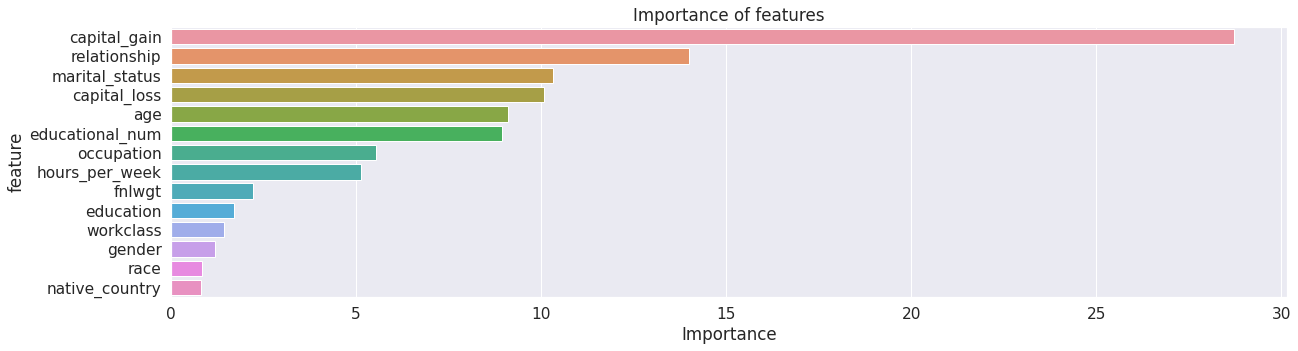

In [ ]:
show_feature_importances(X.columns, model_catb.feature_importances_)

## Выбор порога вероятности для определения класса

In [ ]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

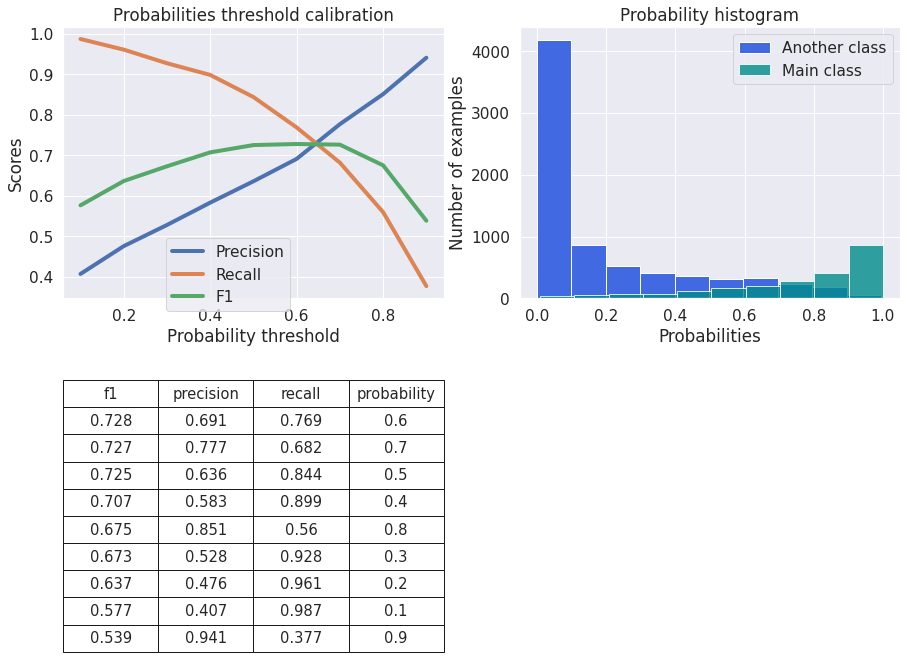

In [ ]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

# Обучение финальной модели и оценка результатов

In [ ]:
final_model = catb.CatBoostClassifier(max_depth=4,
                                      class_weights=[0.7, 1.8], silent=True, random_state=42)
final_model.fit(X, y)

y_pred = final_model.predict(data)
y_pred_probs = final_model.predict_proba(data)

In [ ]:
print(classification_report(data[TARGET_NAME], y_pred))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90     37155
           1       0.65      0.86      0.74     11687

    accuracy                           0.86     48842
   macro avg       0.80      0.86      0.82     48842
weighted avg       0.88      0.86      0.86     48842



In [ ]:
prob_threshold = 0.63

print(classification_report(data[TARGET_NAME], (y_pred_probs[:, 1] > prob_threshold).astype(int)))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     37155
           1       0.74      0.76      0.75     11687

    accuracy                           0.88     48842
   macro avg       0.83      0.84      0.83     48842
weighted avg       0.88      0.88      0.88     48842



Подняли процент precision = 1

## LogisticRegression

In [ ]:
model_catb = LogisticRegression(random_state=42)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)
y_test_pred_probs = model_catb.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.94      0.89     29676
           1       0.71      0.45      0.55      9397

    accuracy                           0.82     39073
   macro avg       0.78      0.70      0.72     39073
weighted avg       0.81      0.82      0.81     39073

TEST

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      7479
           1       0.71      0.45      0.55      2290

    accuracy                           0.83      9769
   macro avg       0.78      0.70      0.72      9769
weighted avg       0.82      0.83      0.81      9769

CONFUSION MATRIX

col_0      0     1
income            
0       7054   425
1       1263  1027


# SVM

In [ ]:
clf = SVC()
clf.fit(X_train, y_train)

SVC()

<p>Снова получаем наш скор, для обучающей и тестовой выборок.</p>

In [ ]:
clf.score(X_train, y_train) 

0.854887006372687

In [ ]:
clf.score(X_test, y_test)

0.8555635172484389

Без нормализации и LabelEncoder



In [ ]:
X = df.drop(columns=TARGET_NAME)
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42)

In [ ]:
clf = SVC()
clf.fit(X_train, y_train)

SVC()

In [ ]:
clf.score(X_train, y_train) 

0.7969185882834694

In [ ]:
clf.score(X_test, y_test)

0.8035622888729655

Без LabelEncoder

In [ ]:
X = df_1.drop(columns=TARGET_NAME)
y = df_1[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42)

In [ ]:
clf = SVC()
clf.fit(X_train, y_train)

SVC()

In [ ]:
clf.score(X_train, y_train) 

0.7969185882834694

In [ ]:
clf.score(X_test, y_test)

0.8035622888729655

## Домашняя работа

https://docs.google.com/document/d/10NOEhBuc9zQCh0VNGLP9y96hj4Agr3k8